Imports:

In [1]:
import tensorflow as tf
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

import glob
import tensorflow_docs.vis.embed as embed
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tensorflow.keras import models, layers
import time

from IPython import display

GAN:

In [11]:
TRAIN_AMOUNT = 20000
BATCH_SIZE = 256

path_celeb = []
train_path_celeb = "/img_align_celeba"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))

select_path=path_celeb[:TRAIN_AMOUNT]
crop = (30, 55, 150, 175) # crop so image has minimal background
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in select_path]

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))

images = np.array(images)
X_train = tf.data.Dataset.from_tensor_slices(images)

In [12]:
X_train = X_train.shuffle(TRAIN_AMOUNT).batch(BATCH_SIZE)

In [13]:
def create_generator():
    generator=models.Sequential()

    generator.add(layers.Dense(4*4*512, input_shape=(100,)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(alpha=0.2))
    generator.add(layers.Reshape([4,4,512]))

    generator.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))
    generator.add(layers.BatchNormalization())

    generator.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))
    generator.add(layers.BatchNormalization())

    generator.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))
    generator.add(layers.BatchNormalization())
    
    generator.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='sigmoid'))

    return generator

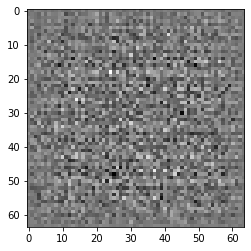

In [20]:
generator = create_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [21]:
def create_discriminator():
    discriminator=models.Sequential()

    discriminator.add(layers.Conv2D(32, kernel_size=4, strides=2, padding="same", input_shape=[64,64,3]))
    discriminator.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same"))
    discriminator.add(layers.LeakyReLU()) 
    discriminator.add(layers.BatchNormalization())
    
    discriminator.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.BatchNormalization())

    discriminator.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same"))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Dropout(0.5))
    
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(1, activation='sigmoid'))

    return discriminator

In [22]:
discriminator = create_discriminator()
decision = discriminator(generated_image)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Epoch {}: {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig('/images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

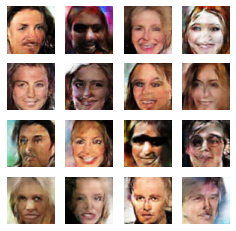

In [26]:
train(X_train, 1000)

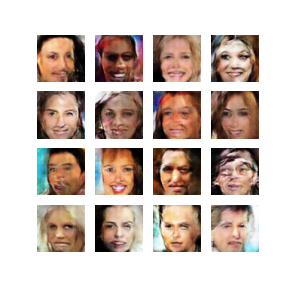

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

def display_image(epoch_no):
    return Image.open('/images/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(819)